# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

# Implementation

In [2]:
class SGD:
    def __init__(self, learning_rate, param_shape=None):
        self.lr = learning_rate
    
    def update(self, w, d_w):
        return w - d_w * self.lr

class StrangeGD:
    def __init__(self, learning_rate, param_shape=None, random_seed=24):
        self.lr = learning_rate
        self.param_size = np.prod(param_shape)
        np.random.seed(random_seed)
        
    def update(self, w, d_w):
        rand_idx = np.random.randint(0, self.param_size)
        new_w = w.copy()
        w_upd = w - self.lr * d_w
        new_w[rand_idx] = w_upd[rand_idx]
        return new_w
    
class Adam:
    def __init__(self, learning_rate, param_shape, beta_1=0.9, beta_2=0.999, eps=1e-8):
        self.lr = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = eps
        self.m_t = np.zeros(param_shape)
        self.v_t = np.zeros(param_shape)
        self.t = 0
        self.beta_1_t = self.beta_1
        self.beta_2_t = self.beta_2
    
    def update(self, w, d_w):
        self.t += 1
        self.m_t = self.beta_1 * self.m_t + (1 - self.beta_1) * d_w
        self.v_t = self.beta_2 * self.v_t + (1 - self.beta_2) * (d_w ** 2)
        self.beta_1_t *= self.beta_1
        self.beta_2_t *= self.beta_2
        m_hat_t = self.m_t / (1 - self.beta_1_t)
        v_hat_t = self.v_t / (1 - self.beta_2_t)
        return w - self.lr * m_hat_t / (np.sqrt(v_hat_t) + self.eps)

# Create a function of two variables

I picked up [three-hump camel function](https://www.sfu.ca/~ssurjano/camel3.html).

Global minimum of the function is at [0, 0] and has value of 0.

In [3]:
def f(w):
    return 2 * w[0] ** 2 - 1.05 * w[0] ** 4 + w[0] ** 6 / 6 + w[0] * w[1] + w[1] ** 2

def g_f(w):
    f_w1 = 4 * w[0] - 4.2 * w[0] ** 3 + w[0] ** 5 + w[1]
    f_w2 = w[0] + 2 * w[1]
    return np.asarray([f_w1, f_w2])

# Find minimum

In [4]:
def find_extremum(algorithm_name, lr, init_w, min_delta=1e-10, max_iter=10 ** 4):
    assert algorithm_name in ["SGD", "StrangeGD", "Adam"]
    
    if algorithm_name == "SGD":
        optim = SGD(learning_rate=lr)
    if algorithm_name == "StrangeGD":
        optim = StrangeGD(learning_rate=lr, param_shape=init_w.shape)
    elif algorithm_name == "Adam":
        optim = Adam(learning_rate=lr, param_shape=init_w.shape)
    
    data = []
    
    f_prev = f(init_w)
    grad_f_prev = g_f(init_w)
    tmp = {
        "step": 0,
        "f": f_prev,
        "grad_f": grad_f_prev,
        "w": init_w
    }
    data.append(tmp)
    w = init_w.copy()
    for i in tqdm.tqdm(range(1, max_iter)):
        w = optim.update(w, grad_f_prev)
        f_next = f(w)
        grad_f_next = g_f(w)
        tmp = {
            "step": i,
            "f": f_next,
            "grad_f": grad_f_next,
            "w": w
        }
        data.append(tmp)
        
        if np.abs(f_prev - f_next) <= min_delta:
            break
            
        if np.linalg.norm(grad_f_next) <= min_delta:
            break
        
        f_prev = f_next
        grad_f_prev = grad_f_next.copy()
        
    return data

In [5]:
lr = 0.001

data = {}
w = np.asarray([-1., 1.])
    
for algorithm_name in ["SGD", "StrangeGD", "Adam"]:
    data[algorithm_name] = find_extremum(algorithm_name, lr, w)

 15%|█▌        | 1500/9999 [00:00<00:00, 21788.74it/s]


# Plot the approximations

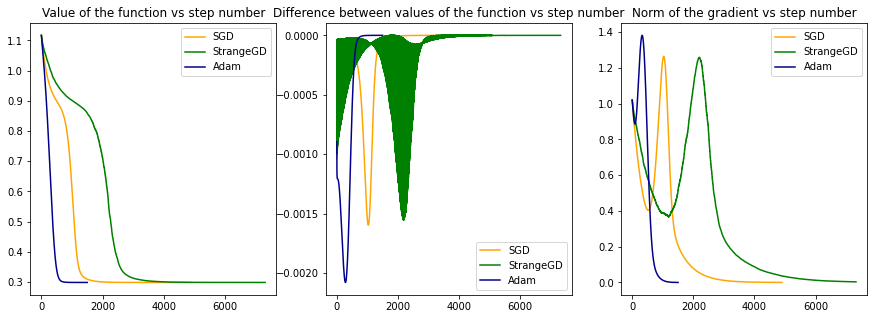

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

for algorithm_name, color in zip(["SGD", "StrangeGD", "Adam"], ["orange", "green", "darkblue"]):
    df = pd.DataFrame(data[algorithm_name])
    ax[0].plot(df["step"], df["f"], color=color, label=algorithm_name)
    ax[1].plot(df["step"].values[1:], np.diff(df["f"].values), color=color, label=algorithm_name)
    ax[2].plot(df["step"], df["grad_f"].map(lambda x: np.linalg.norm(x)), color=color, label=algorithm_name)

ax[0].set_title("Value of the function vs step number")
ax[1].set_title("Difference between values of the function vs step number")
ax[2].set_title("Norm of the gradient vs step number")
    
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

What do we see there:

* As the function has several extremums, it requires some time for SGD and axis-selecting GD (StrangeGD) to come out of the local minimum. 
* Adam does it faster.